# Dual Diffusion Implicit Bridges for Image-to-Image Translation

In this notebook, we work through example domain translation code for synthetic datasets and ImageNet classes.

## Installation

Our repository is based on the [guided-diffusion](https://github.com/openai/guided-diffusion) project from OpenAI.

We follow similar installation procedures. First, we clone the DDIBs repository.

In [ ]:
!git clone https://github.com/suxuann/ddib.git

Cloning into 'ddib'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 99 (delta 34), reused 82 (delta 20), pack-reused 0
Receiving objects: 100% (99/99), 13.93 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (34/34), done.


Next, we install the project and a couple of libraries like `numpy` and `matplotlib`. The version numbers here are slightly different from the ones listed on GitHub.

If you encounter `Restart Runtime`, click the button, and run the same cell again.

In [ ]:
%cd ./ddib
!pip install -e .
!pip install numpy==1.21.6 matplotlib==3.1.3 scikit-image==0.19.3
!pip install scikit-learn==1.2.0 gdown==4.6.0 mpi4py==3.1.4

Remember to use GPU as the runtime type, under Runtime → Change runtime type.

In [ ]:
import torch

device = torch.device("cuda")

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np

import torch
import torch.nn as nn

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

In [ ]:
BATCH_SIZE = 8

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    random_color,
    #transforms.Normalize([0.5],[0.5])
])

# Load train datasets
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)

mnist_2 = list(filter(lambda i: i[1] == 2, mnist))
mnist_2_loader = torch.utils.data.DataLoader(mnist_2, batch_size=BATCH_SIZE, shuffle=False)

mnist_3 = list(filter(lambda i: i[1] == 3, mnist))
mnist_3_loader = torch.utils.data.DataLoader(mnist_3, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
next(iter(mnist_2_loader))[0].max(), next(iter(mnist_2_loader))[0].min()

(tensor(1.), tensor(0.))

Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets


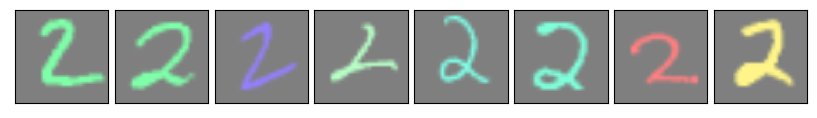

In [ ]:
def plot_images(batch):
    fig, axes = plt.subplots(1, 8, figsize=(8, 1), dpi=100)
    for i in range(8):
        axes[i].imshow(batch[i].mul(0.5).add(0.5).clip(0,1).permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

print('Random (unpaired) images from MNIST (1st row) and USPS (2nd row) train sets')
plot_images(next(iter(mnist_2_loader))[0])

In [ ]:
"""
Train a diffusion model on 2D synthetic datasets.
"""

import argparse
import os

from guided_diffusion import dist_util, logger
from guided_diffusion.resample import create_named_schedule_sampler
from guided_diffusion.script_util import model_and_diffusion_defaults, create_model_and_diffusion, args_to_dict, \
    add_dict_to_argparser
from guided_diffusion.synthetic_datasets import Synthetic2DType, load_2d_data
from guided_diffusion.train_util import TrainLoop


def train(data_l):
    args = create_argparser().parse_args(args=[])
    print(f"args: {args}")

    dist_util.setup_dist()
    logger.configure()

    logger.log("creating 2d model and diffusion...")
    model, diffusion = create_model_and_diffusion(
        **args_to_dict(args, model_and_diffusion_defaults().keys())
    )
    model.to(dist_util.dev())
    schedule_sampler = create_named_schedule_sampler(args.schedule_sampler, diffusion)

    logger.log("creating 2d data loader...")
    data = data_l
    # data = load_2d_data(
    #     batch_size=args.batch_size,
    #     shape=list(Synthetic2DType)[args.task]
    # )

    logger.log("training 2d model...")
    TrainLoop(
        model=model,
        diffusion=diffusion,
        data=data,
        batch_size=args.batch_size,
        microbatch=args.microbatch,
        lr=args.lr,
        ema_rate=args.ema_rate,
        log_interval=args.log_interval,
        save_interval=args.save_interval,
        resume_checkpoint=args.resume_checkpoint,
        use_fp16=args.use_fp16,
        fp16_scale_growth=args.fp16_scale_growth,
        schedule_sampler=schedule_sampler,
        weight_decay=args.weight_decay,
        lr_anneal_steps=args.lr_anneal_steps,
    ).run_loop()


def create_argparser():
    defaults = dict(
        data_dir="/content/ddib/models/mnist_3",
        schedule_sampler="uniform",
        lr=1e-4,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=1,
        microbatch=-1,  # -1 disables microbatches
        ema_rate="0.9999",  # comma-separated list of EMA values
        log_interval=10,
        save_interval=20,
        resume_checkpoint="",
        use_fp16=False,
        fp16_scale_growth=1e-3,
    )
    defaults.update(model_and_diffusion_defaults())
    parser = argparse.ArgumentParser()
    add_dict_to_argparser(parser, defaults)
    return parser

os.environ['DIFFUSION_BLOB_LOGDIR'] = "/content/ddib/models/mnist_3"
os.environ["OPENAI_LOGDIR"] = "/content/ddib/models/mnist_3"
train(iter(mnist_3_loader))

args: Namespace(data_dir='/content/ddib/models/mnist_3', schedule_sampler='uniform', lr=0.0001, weight_decay=0.0, lr_anneal_steps=0, batch_size=1, microbatch=-1, ema_rate='0.9999', log_interval=10, save_interval=20, resume_checkpoint='', use_fp16=False, fp16_scale_growth=0.001, image_size=256, num_channels=128, num_res_blocks=2, num_heads=4, num_heads_upsample=-1, num_head_channels=-1, attention_resolutions='16,8', channel_mult='', dropout=0.0, class_cond=False, use_checkpoint=False, use_scale_shift_norm=True, resblock_updown=False, use_new_attention_order=False, in_channels=3, learn_sigma=False, diffusion_steps=1000, noise_schedule='linear', timestep_respacing='', use_kl=False, predict_xstart=False, rescale_timesteps=False, rescale_learned_sigmas=False)
Logging to /content/ddib/models/mnist_3
creating 2d model and diffusion...
creating 2d data loader...
training 2d model...
-------------------------
| grad_norm  | 27.1     |
| loss       | 1        |
| loss_q0    | 1        |
| loss_q

StopIteration: ignored

In [ ]:
from argparse import Namespace

from guided_diffusion.script_util import model_and_diffusion_defaults

defaults = model_and_diffusion_defaults()

args = Namespace(**defaults)
print(f"Arguments: {args}")

Arguments: Namespace(image_size=256, num_channels=128, num_res_blocks=2, num_heads=4, num_heads_upsample=-1, num_head_channels=-1, attention_resolutions='16,8', channel_mult='', dropout=0.0, class_cond=False, use_checkpoint=False, use_scale_shift_norm=True, resblock_updown=False, use_fp16=False, use_new_attention_order=False, in_channels=3, learn_sigma=False, diffusion_steps=1000, noise_schedule='linear', timestep_respacing='', use_kl=False, predict_xstart=False, rescale_timesteps=False, rescale_learned_sigmas=False)


Next, we load the dataset, and the source and target models:

In [ ]:
from scripts.common import read_model_and_diffusion

# Load the dataset
source = next(iter(mnist_2_loader))[0].to(device)
print(f"Data shape: {source.shape}")

source_dir = "/content/ddib/models/mnist_2"
source_model, diffusion = read_model_and_diffusion(args, source_dir, synthetic=False)

Data shape: torch.Size([8, 3, 256, 256])
Model path: /content/ddib/models/mnist_2/model000100.pt


In [ ]:
target_dir = "/content/ddib/models/mnist_3"
target_model, _ = read_model_and_diffusion(args, target_dir, synthetic=False)

Model path: /content/ddib/models/mnist_3/model000120.pt


## Encoding Step: Source → Latent

In [ ]:
import time

start = time.time()
noise = diffusion.ddim_reverse_sample_loop(
    source_model, source,
    clip_denoised=False,
    device=device
)
end = time.time()

print(f"Noise shape: {noise.shape}")
print(f"Time taken for the encoding step: {end - start} seconds")

Noise shape: torch.Size([8, 3, 256, 256])
Time taken for the encoding step: 894.464839220047 seconds


In [ ]:
from PIL import Image

source_images = list()
for i in range(source.shape[0]):
    print(source[i].shape)
    sample = source[i]
    sample = ((sample * 2) * 127.5).clamp(0, 255).to(torch.uint8)
    sample = sample.permute(1, 2, 0)
    sample = sample.contiguous()
    image = Image.fromarray(sample.cpu().numpy())
    source_images.append(image)
print(f"created {len(source_images)} samples")

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
created 8 samples


In [ ]:
noise_images = list()
for i in range(noise.shape[0]):
    print(noise[i].shape)
    sample = noise[i]
    sample = ((sample * 2) * 127.5).clamp(0, 255).to(torch.uint8)
    sample = sample.permute(1, 2, 0)
    sample = sample.contiguous()
    image = Image.fromarray(sample.cpu().numpy())
    noise_images.append(image)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


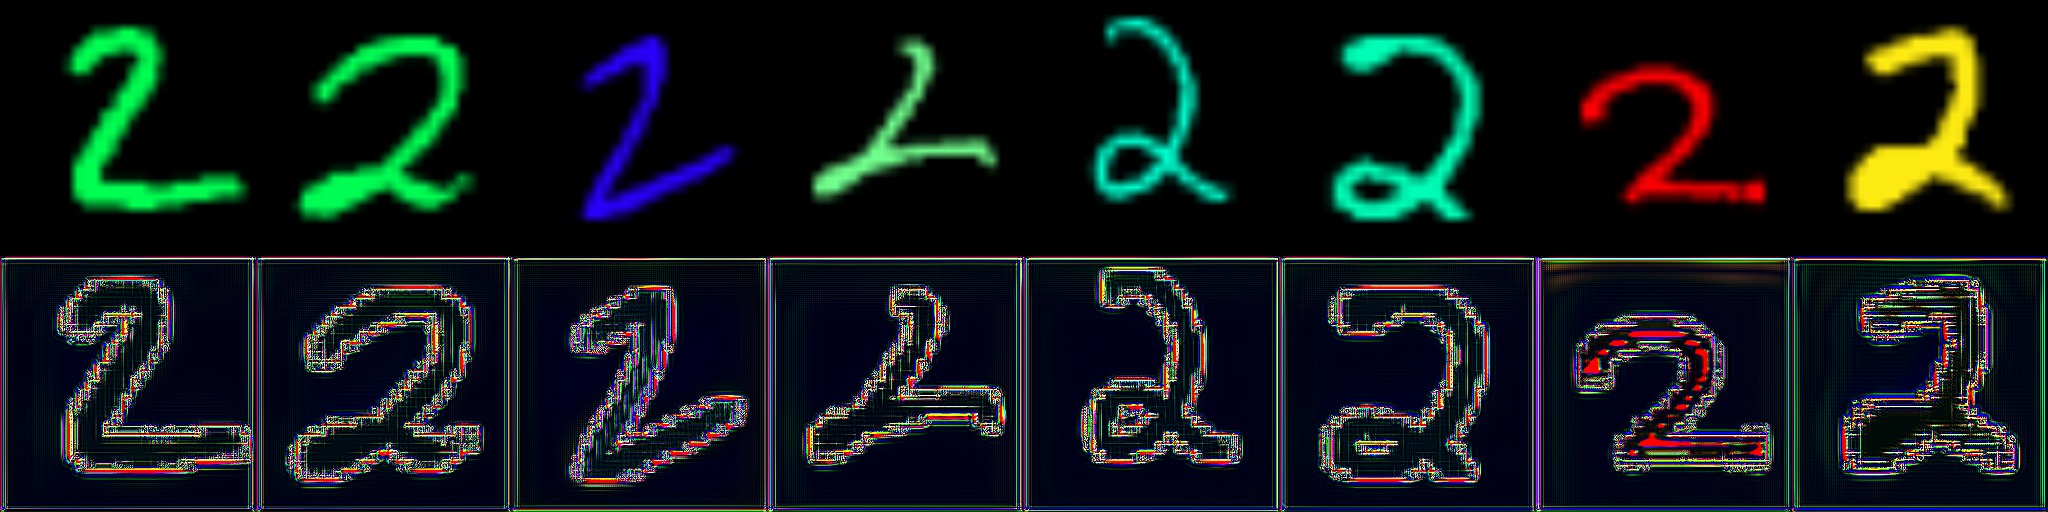

In [ ]:
# Display the images in grid
images = source_images + noise_images
#images = target_images
grid = image_grid(images, 2, len(images) // 2)
grid

## Decoding Step: Latent → Target

In [ ]:
import time

start = time.time()
target = diffusion.ddim_sample_loop(
    target_model, (8, 3, 256, 256),
    noise=noise,
    clip_denoised=False,
    device=device,
)
end = time.time()

print(f"Target shape: {noise.shape}")
print(f"Time taken for the decoding step: {end - start} seconds")

Target shape: torch.Size([8, 3, 256, 256])
Time taken for the decoding step: 896.916097164154 seconds


In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [ ]:
from PIL import Image

# Save the samples as PIL images
target_images = list()
for i in range(target.shape[0]):
    sample = ((target[i] * 2) * 127.5).clamp(0, 255).to(torch.uint8)
    sample = sample.permute(1, 2, 0)
    sample = sample.contiguous()
    image = Image.fromarray(sample.cpu().numpy())
    target_images.append(image)
print(f"created {len(target_images)} samples")

created 8 samples


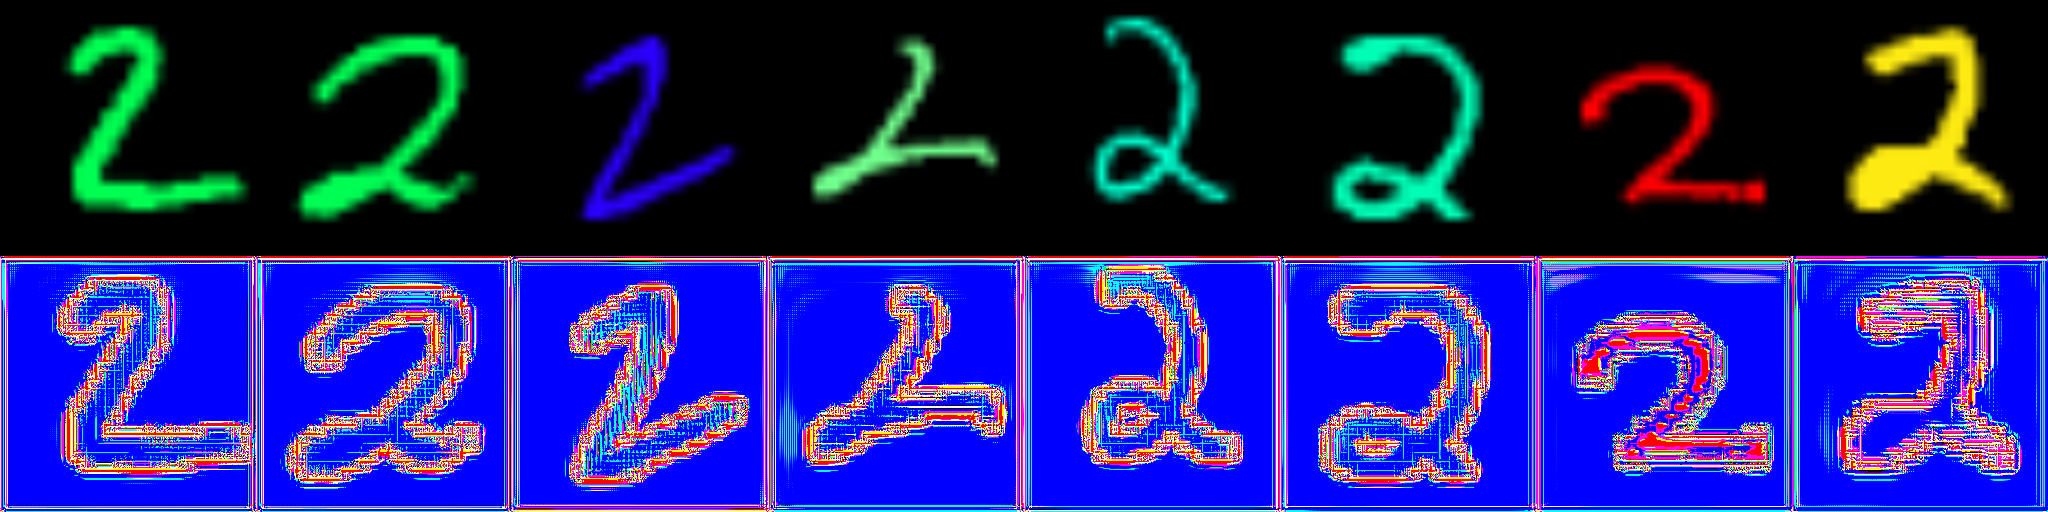

In [ ]:
# Display the images in grid
images = source_images + target_images
#images = target_images
grid = image_grid(images, 2, len(images) // 2)
grid